## Evaluation and Visualisation of Results on PLAsTiCC with `t2` on Balanced data

In [24]:
import argparse
import joblib
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import seaborn as sns
import tensorflow as tf

from itertools import cycle
from numpy import interp
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow import keras

from astronet.constants import astronet_working_directory as asnwd
from astronet.preprocess import one_hot_encode
from astronet.utils import astronet_logger, load_dataset

In [25]:
from astronet.metrics import WeightedLogLoss
from astronet.visualise_results import plot_acc_history, plot_confusion_matrix, plot_loss_history, plot_multiROC

In [26]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import random as python_random
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [27]:
mpl.style.use("seaborn-whitegrid")

In [28]:
architecture = "t2"

In [29]:
dataset = "plasticc"

In [30]:
X_train, y_train, X_test, y_test, loss = load_dataset(dataset, balance=True)

/usr/local/anaconda3/envs/astronet/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [31]:
num_classes = y_train.shape[1]
num_classes

3

In [32]:
model_name = None
        
with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results.json") as f:
    events = json.load(f)
    if model_name is not None:
    # Get params for model chosen with cli args
        event = next(item for item in events['training_result'] if item["name"] == model_name)
    else:
        # Get params for best model with lowest loss
        event = min(
            (item for item in events["training_result"] if item["balanced_classes"] is not None),
                key=lambda ev: ev["model_evaluate_on_test_loss"],
            )

#         event = min(events['training_result'], key=lambda ev: ev['model_evaluate_on_test_loss'])

In [33]:
# Show short summary of items in 'event'
dict(list(event.items())[1:4])

{'balanced_classes': True, 'embed_dim': 32, 'ff_dim': 512}

In [34]:
model_name = event['name']
model_name

'1612112200-406427a'

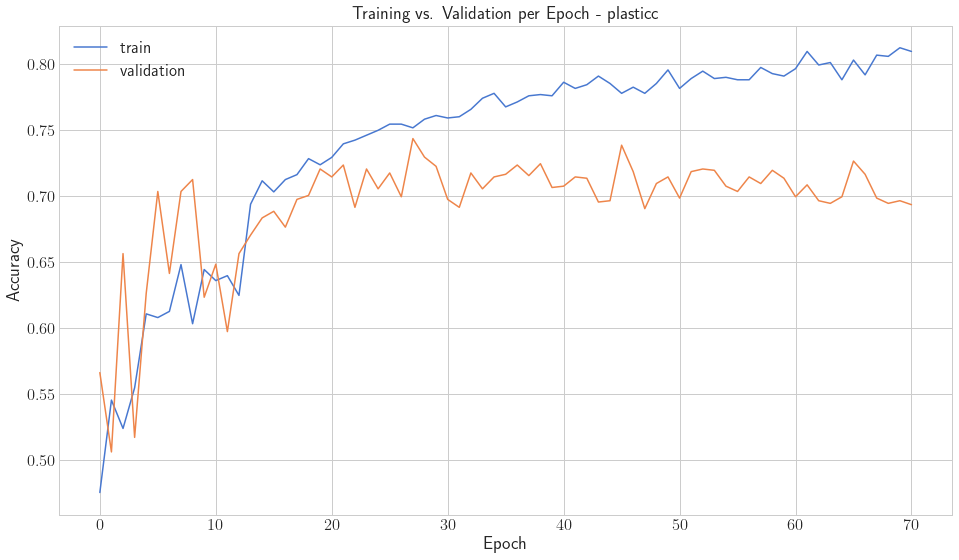

In [35]:
plot_acc_history(dataset, model_name, event, save=False)

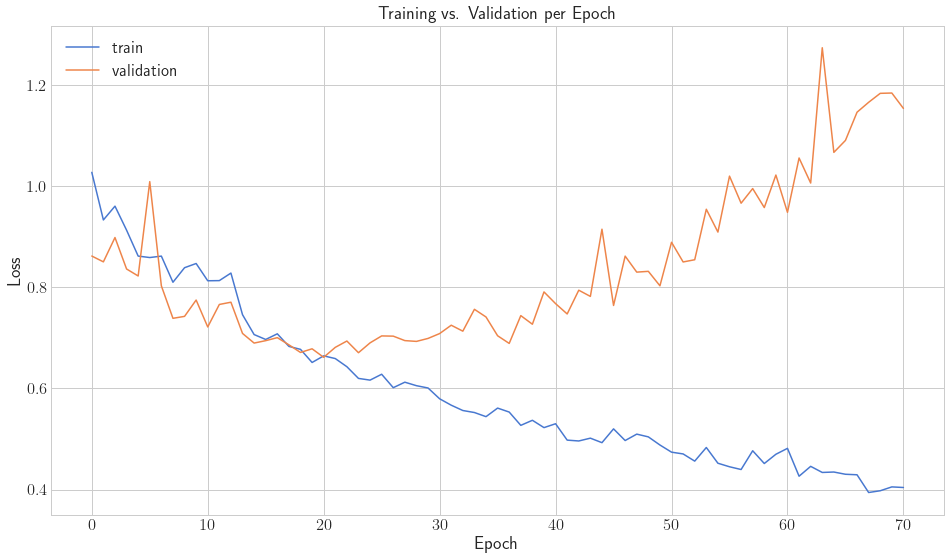

In [36]:
plot_loss_history(dataset, model_name, event, save=False)

In [37]:
model = keras.models.load_model(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}", 
                                custom_objects={'WeightedLogLoss': WeightedLogLoss()}, 
                               compile=False)

In [38]:
with open(f"{asnwd}/data/{dataset}.encoding", "rb") as eb:
    encoding = joblib.load(eb)
class_encoding = encoding.categories_[0]

if dataset == "plasticc":
    class_mapping = {
        15: "TDE",
        42: "SNII",
        52: "SNIax",
        62: "SNIbc",
        64: "KN",
        67: "SNIa-91bg",
        88: "AGN",
        90: "SNIa",
        95: "SLSN-I",
        1: "SNIa",
        2: "SNII",
        3: "SNIbc",
    }

    class_encoding
    class_names = list(np.vectorize(class_mapping.get)(class_encoding))
else:

    class_names = class_encoding

In [39]:
from collections import Counter
from pandas.core.common import flatten

y_true = encoding.inverse_transform(y_train)
Counter(list(flatten(y_true)))

Counter({42: 357, 62: 357, 90: 357})

In [40]:
logloss = event["model_evaluate_on_test_loss"]
acc = event["model_evaluate_on_test_acc"]
print(f"LogLoss on Test Set: {logloss}, Accuracy on Test Set: {acc}")

wloss = WeightedLogLoss()

y_preds = model.predict(X_test)
print(f"LL-Test: {wloss(y_test, y_preds).numpy():.2f}")

y_preds_train = model.predict(X_train)
print(f"LL-Train: {wloss(y_train, y_preds_train).numpy():.2f}")
# Note the discreptancy seems to be down to inconsistant seeds - see 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

LogLoss on Test Set: 0.6735103726387024, Accuracy on Test Set: 0.7144288420677185
LL-Test: 0.68
LL-Train: 0.62


1612112200-406427a


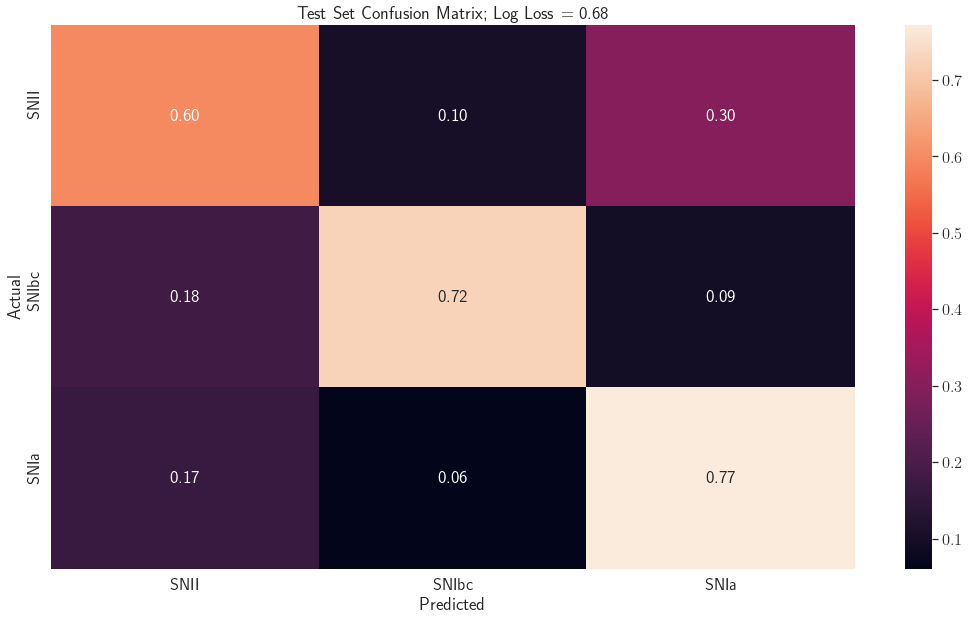

In [41]:
plot_confusion_matrix(
    dataset,
    model_name,
    y_test,
    y_preds,
    encoding, 
    class_names,  # enc.categories_[0]
    save=False,
)

1612112200-406427a


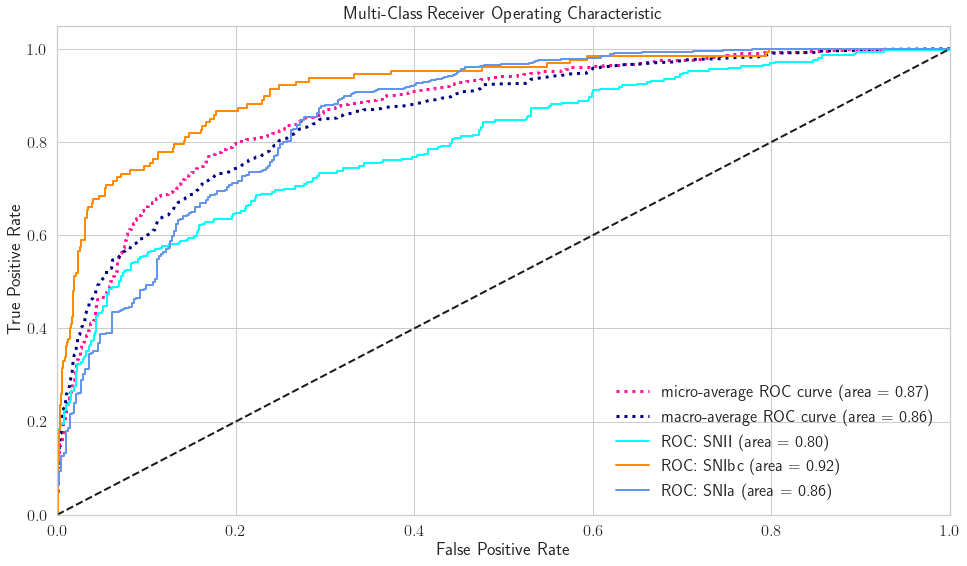

In [42]:
plot_multiROC(dataset, model_name, model, X_test, y_test, class_names, save=False)

## `snmachine` Benchmark Comparisons

As mentioned in https://github.com/tallamjr/astronet/issues/44 one would like to compare performance with the reuslts shown below:
    
<img src="https://user-images.githubusercontent.com/8843728/101194521-04c46800-3656-11eb-9b8c-fc2f30f88cf5.png" width="800">

> The goal would be to compare with the table below, specifically **LL_test**, with no redshift (**z**) information:

From the results obtained for the `t2` model, a weighted log-loss score of $$LL_{test} = 0.67$$ as well as $$LL_{train} = 0.59$$

The AUC measurements for $AUC_{test}$ only, since we have only evaluated on the test set are: <br>
$$AUC_{test}SNIa = 0.90$$ $$AUC_{test}SNII = 0.84$$ $$AUC_{test}SNIbc = 0.88$$

**Comments**: It should be noted that from the loss vs epochs graph above, one can clearly see that a lower loss is achieable, and it is expected that this was not saved as the final model since the `EarlyStopping` criteria was _monitoring_ the `loss` instead of the `val_loss`. This can be updated which may allow for a $LL_{test} ~ 0.6$.

Furthermore, it may be seen that from the same graph, the validation loss plataeus at ~ 0.86, but the reported $LL_{test} ~ 0.93$, why? 

This seems to be a case of random seeds. This has been looked into with additions of `PYTHONHASHSEED=0` added as an environment variable. See these [Keras FAQs](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for details.